###                                           Statistical Learning individual assignment - Rémi Colombier

###### Load libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score  
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.metrics import accuracy_score as acc
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import svm

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
#read the data from csv
data = pd.read_csv("C:/Users/rcolombier/OneDrive/Documents/Statistical machine learning/individual assignment/credit_default_train.csv")

In [17]:
#check the null values
data.isna().sum()

cust_id                         0
LIMIT_BAL                     202
SEX                           161
EDUCATION                     199
MARRIAGE                      170
AGE                           214
PAY_0                         195
PAY_2                         219
PAY_3                         217
PAY_4                         199
PAY_5                         185
PAY_6                         203
BILL_AMT1                     185
BILL_AMT2                     209
BILL_AMT3                     175
BILL_AMT4                     165
BILL_AMT5                     181
BILL_AMT6                     197
PAY_AMT1                      204
PAY_AMT2                      184
PAY_AMT3                      212
PAY_AMT4                      197
PAY_AMT5                      179
PAY_AMT6                      196
default.payment.next.month      0
dtype: int64

In [3]:
#fill all the na values in order to run the algorithm
data = data.fillna(0)

### Run the five algorithms without features selection & cross validation

In [4]:
#create train and test set
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [33]:
#initialize decision tree, logistic, random forest and knn algorithm 
decision_tree = DecisionTreeClassifier()
logistic = LogisticRegression()
random_forest = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors = 3)

In [34]:
models = {
    "logistic" : logistic,
    "decision_tree" : decision_tree,
    "random_forest": random_forest, 
    "knn": knn 
}

In [35]:
#fitting the models with the for loop
for model in models:
    models[model].fit(X_train,y_train)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
#train the model in the train set for the 4 algorithms and compute the accuracy score
performances_training = {}
for model in models:
    predictions = models[model].predict(X_train)
    probabilities = pd.DataFrame(models[model].predict_proba(X_train))[1]
    accuracy = accuracy_score(y_train, predictions)
    auc = roc_auc_score(y_train, predictions)
    performances_training[model] = {"Accuracy":accuracy, "AUC": auc}

In [37]:
#display the training performance of our 4 models
pd.DataFrame(performances_training)

,logistic,decision_tree,random_forest,knn
Accuracy,0.777438,1.0,1.0,0.840500
AUC,0.500442,1.0,1.0,0.707525


##### Compute the same for test set 

In [38]:
#test the model in the test set for the 4 algorithms and compute the accuracy & AUC score
performances_testing = {}
for model in models:
    predictions = models[model].predict(X_test)
    probabilities = pd.DataFrame(models[model].predict_proba(X_test))[1]
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)
    performances_testing[model] = {"Accuracy":accuracy, "AUC":auc}

In [39]:
#display the training performance of our 4 models
pd.DataFrame(performances_testing)

,logistic,decision_tree,random_forest,knn
Accuracy,0.785250,0.724500,0.828500,0.728500
AUC,0.500106,0.617609,0.665116,0.546317


###### Initilialize SVM classifier

In [40]:
#we define the classifier with the default parameters 
svc = SVC()

#default parameter
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state = None, shrinking=True,
    tol=0.001, verbose=False)

SVC()

In [54]:
#we fit the model with train dataset and we compute accuracy score
svc.fit(X_train, y_train)
score = svc.score(X_train, y_train)
print("Accuracy : ", score)

Accuracy :  0.7779375


In [44]:
#initialize svm
clf = svm.SVC()

#fit the model
clf.fit(X_train, y_train)

#predict
y_pred_train = clf.predict(X_train)

In [46]:
#compute AUC score with train set
AUC = metrics.roc_auc_score(y_train, y_pred_train)
AUC


0.5005622715771718

##### score for test set 

In [53]:
#we fit the model with train dataset and we compute accuracy score
svc.fit(X_test, y_test)
score = svc.score(X_test, y_test)
print("Accuracy: ", score)

Accuracy:  0.786


In [50]:
#predict with X_test
y_pred_test = clf.predict(X_test)

In [52]:
#compute AUC score with test set
AUC = metrics.roc_auc_score(y_test, y_pred_test)
AUC

0.5

# Feature selection and cross validation 

## 1) Random forest 

###### 1.1 Features selection Random Forest

In [16]:
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.8min finished

[2022-03-30 18:57:19] Features: 1/5 -- score: 0.81325[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  1.4min finished

[2022-03-30 18:58:44] Features: 2/5 -- score: 0.8140000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  1.2min finished

[2022-03-30 18:59:58] Features: 3/5 -- score: 0.81425[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 

In [17]:
# Which features?
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[3, 6, 7, 8, 9]


###### 1.2 Cross validation - Random Forest

In [8]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [12]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
random_forest_cv = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

###### 1.3 fit the model with features selection and cross validation

In [42]:
#select only the values selected above with features selection 
X_rf= data.iloc[:,[3, 6, 7, 8, 9]].values
X_train_rf,X_test_rf,y_train_rf,y_test_rf = train_test_split(X_rf,y,test_size = 0.2,random_state = 42)

In [49]:
# Fit the random search model
random_forest_cv.fit(X_train_rf, y_train_rf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=42, verbose=2)

In [40]:
#train the model in the train set for logistic regression with feature selection and compute the accuracy score
performances_training = {}
predictions = random_forest_cv.predict(X_train_rf)
probabilities = pd.DataFrame(random_forest_cv.predict_proba(X_train_rf))[1]
accuracy = accuracy_score(y_train_rf, predictions)
auc = roc_auc_score(y_train_rf, predictions)
performances_training[random_forest_cv] = {"Accuracy":accuracy, "AUC":auc}

In [41]:
performances_training

{RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                    n_jobs=-1,
                    param_distributions={'bootstrap': [True, False],
                                         'max_depth': [10, 20, 30, 40, 50, None],
                                         'max_features': ['auto', 'sqrt'],
                                         'min_samples_leaf': [1, 2, 4],
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [200, 400, 600, 800,
                                                          1000]},
                    random_state=42, verbose=2): {'Accuracy': 0.826625,
  'AUC': 0.6550369883463647}}

In [30]:
#predict and test the model in the test set for the logistic regression and compute the accuracy score
performances_test = {}
predictions = random_forest_cv.predict(X_test_rf)
probabilities = pd.DataFrame(random_forest_cv.predict_proba(X_test_rf))[1]
accuracy = accuracy_score(y_test_rf, predictions)
auc = roc_auc_score(y_test_rf, predictions)
performances_test[random_forest_cv] = {"Accuracy":accuracy, "AUC":auc}

In [31]:
performances_test

{RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                    n_jobs=-1,
                    param_distributions={'bootstrap': [True, False],
                                         'max_depth': [10, 20, 30, 40, 50, None],
                                         'max_features': ['auto', 'sqrt'],
                                         'min_samples_leaf': [1, 2, 4],
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [200, 400, 600, 800,
                                                          1000]},
                    random_state=42, verbose=2): {'Accuracy': 0.825,
  'AUC': 0.665010612384915}}

# 2) Logistic regression 

###### 2.1 Features importance - Logistic regression 

In [29]:
logistic = LogisticRegression()

In [30]:
logistic.fit(X,y)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Feature: 0, Score: -0.00003
Feature: 1, Score: -0.00000
Feature: 2, Score: -0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: -0.00000
Feature: 5, Score: -0.00003
Feature: 6, Score: 0.00001
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00001
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: -0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: -0.00003
Feature: 19, Score: -0.00003
Feature: 20, Score: -0.00001
Feature: 21, Score: -0.00002
Feature: 22, Score: -0.00001
Feature: 23, Score: -0.00000


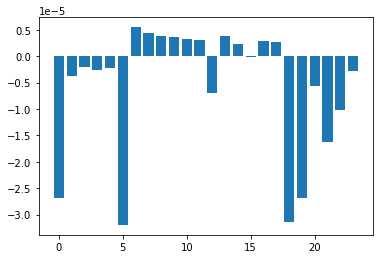

In [34]:
from matplotlib import pyplot
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Here we can see that there is no clear pattern in importances of the features

###### 2.2 Cross validation - Logistic regression 

In [63]:
# Perform GridSearchCV to tune best-fit LR model
param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(X_train, y_train)

# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [64]:
#apply the best fit parameters compute above to the logistic regression
model2 = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

 ###### 2.3 Fit the logistic model with cross validation parameters

In [65]:
#fit the model to the train set
model2.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [66]:
#predict on the test set
y_pred = model2.predict(X_test)

In [70]:
#train the model in the train set for logistic regression with feature selection and compute the accuracy score
performances_training = {}
predictions = model2.predict(X_train)
probabilities = pd.DataFrame(model2.predict_proba(X_train))[1]
accuracy = accuracy_score(y_train, predictions)
auc = roc_auc_score(y_train, predictions)
performances_training[model2] = {"Accuracy":accuracy, "AUC":auc}

In [71]:
#display the new training performance of logistic regression on the train set
performances_training

{LogisticRegression(C=0.1, penalty='l1', solver='liblinear'): {'Accuracy': 0.804875,
  'AUC': 0.5917643549327695}}

In [73]:
#predict and test the model in the test set for the logistic regression and compute the accuracy score
performances_test = {}
predictions = model2.predict(X_test)
probabilities = pd.DataFrame(model2.predict_proba(X_test))[1]
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
performances_test[model2] = {"Accuracy":accuracy, "AUC":auc}

In [74]:
#display the test performance of logistic regression on the test set
performances_test

{LogisticRegression(C=0.1, penalty='l1', solver='liblinear'): {'Accuracy': 0.8225,
  'AUC': 0.6146198828238263}}

We can see that the gap between train and test accuracy is reduce a lot. Then the model is far more accurate than without features selection and cross validation

# 3) Decision tree algorithm 

###### 3.1     Features importances - Decision Tree

In [40]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

In [41]:
decision_tree = DecisionTreeRegressor()

In [43]:
decision_tree.fit(X,y)

DecisionTreeRegressor()

Feature: 0, Score: 0.09154
Feature: 1, Score: 0.04884
Feature: 2, Score: 0.01319
Feature: 3, Score: 0.02010
Feature: 4, Score: 0.01380
Feature: 5, Score: 0.05613
Feature: 6, Score: 0.15011
Feature: 7, Score: 0.03203
Feature: 8, Score: 0.00863
Feature: 9, Score: 0.01333
Feature: 10, Score: 0.00789
Feature: 11, Score: 0.01233
Feature: 12, Score: 0.06019
Feature: 13, Score: 0.04335
Feature: 14, Score: 0.03921
Feature: 15, Score: 0.04069
Feature: 16, Score: 0.04406
Feature: 17, Score: 0.04530
Feature: 18, Score: 0.03896
Feature: 19, Score: 0.05251
Feature: 20, Score: 0.03601
Feature: 21, Score: 0.04109
Feature: 22, Score: 0.04196
Feature: 23, Score: 0.04874


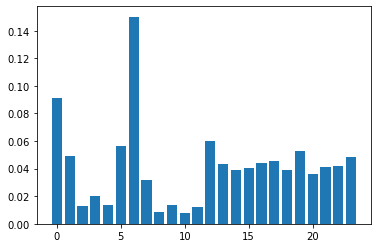

In [45]:
importance = decision_tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Result show that we could take features 0,5,6,12,19 according to the more importance there is to explain Y

###### 3.2 Cross validation - Decision Tree

In [17]:
#Let's do cross validation to select the best parameters for our decision tree algorithm
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

 ###### 3.3 Fit the logistic model with cross validation parameters and features selection

In [15]:
#select only the values selected above with features importances 
X_dt= data.iloc[:,[0,5,6,12,19]].values
X_train_dt,X_test_dt,y_train_dt,y_test_dt = train_test_split(X_dt,y,test_size = 0.2,random_state = 42)

In [18]:
grid_search_cv.fit(X_train_dt, y_train_dt)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [79]:
y_pred = grid_search_cv.predict(X_test)

In [20]:
performances_training = {}
predictions = grid_search_cv.predict(X_train_dt)
probabilities = pd.DataFrame(grid_search_cv.predict_proba(X_train_dt))[1]
accuracy = accuracy_score(y_train_dt, predictions)
auc = roc_auc_score(y_train_dt, predictions)
performances_training[grid_search_cv] = {"Accuracy":accuracy, "AUC":auc}

In [21]:
#show the train results
performances_training

{GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
              param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19, 20, 21,
                                             22, 23, 24, 25, 26, 27, 28, 29, 30,
                                             31, ...],
                          'min_samples_split': [2, 3, 4]},
              verbose=1): {'Accuracy': 0.8133125, 'AUC': 0.6327252609261178}}

In [22]:
#predict and test the model in the test set for the logistic regression and compute the accuracy score
performances_test = {}
predictions = grid_search_cv.predict(X_test_dt)
probabilities = pd.DataFrame(grid_search_cv.predict_proba(X_test_dt))[1]
accuracy = accuracy_score(y_test_dt, predictions)
auc = roc_auc_score(y_test_dt, predictions)
performances_test[grid_search_cv] = {"Accuracy":accuracy, "AUC":auc}

In [23]:
#show the test results
performances_test

{GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
              param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19, 20, 21,
                                             22, 23, 24, 25, 26, 27, 28, 29, 30,
                                             31, ...],
                          'min_samples_split': [2, 3, 4]},
              verbose=1): {'Accuracy': 0.83225, 'AUC': 0.6594397135974035}}

# 4) K-Nearest neighbours’ algorithm

###### 4.1 Cross validation - KNN

In [43]:
from sklearn.model_selection import cross_val_score
import numpy as np#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X, y, cv=5)#print each cv score (accuracy) and average them
print(cv_scores)
print("cv_scores mean:{}".format(np.mean(cv_scores)))

[0.726   0.72575 0.72525 0.72875 0.72575]
cv_scores mean:0.7263000000000001


In [88]:
#create new a knn model
from sklearn.model_selection import GridSearchCV

#create a dictionary of all values we want to test for n_neighbors
knn2 = KNeighborsClassifier()

#use gridsearch to test all values for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 25)}

###### 4.2 Fit the model with cross validation

In [92]:
#fit model to data
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [93]:
performances_training = {}
predictions = knn_gscv.predict(X_train)
probabilities = pd.DataFrame(knn_gscv.predict_proba(X_train))[1]
accuracy = accuracy_score(y_train, predictions)
auc = roc_auc_score(y_train, predictions)
performances_training[knn_gscv] = {"Accuracy":accuracy, "AUC":auc}

In [94]:
performances_training

{GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
              param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24])}): {'Accuracy': 0.7825,
  'AUC': 0.5294952743859765}}

In [95]:
#predict and test the model in the test set for the logistic regression and compute the accuracy score
performances_test = {}
predictions = knn_gscv.predict(X_test)
probabilities = pd.DataFrame(knn_gscv.predict_proba(X_test))[1]
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
performances_test[knn_gscv] = {"Accuracy":accuracy, "AUC":auc}

In [96]:
performances_test

{GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
              param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24])}): {'Accuracy': 0.78475,
  'AUC': 0.522278397550297}}

# 5) Support Vector Machine Algorithm

###### 5.1 Cross validation - Support vector machine

In [33]:
#we define the classifier with the default parameters 
svc = SVC()
print(svc)

SVC()


In [34]:
#default parameter
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

SVC()

In [35]:
#fit support vector machine model
svc.fit(X_train, y_train)

SVC()

In [36]:
#we can also apply an accuracy score to our train set with 10 fold cross validation

cv_scores = cross_val_score(svc, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.78


In [37]:
#we can also apply an accuracy score to our test set with 10 fold cross validation

cv_scores_test = cross_val_score(svc, X_test, y_test, cv=10)
print("CV average score: %.2f" % cv_scores_test.mean())

CV average score: 0.79
